### **Imports and utils**

Importing libraies

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Concatenate, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import Accuracy
#from sklearn.model_selection import train_test_split

2024-01-27 14:17:13.746005: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 14:17:13.854095: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 14:17:14.016220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 14:17:14.016381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 14:17:14.029914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Utils functions

In [7]:
def read_header_and_data(file_path, idx):
    with fits.open(file_path) as hdu:
        header = hdu[idx].header
        data = hdu[idx].data

        return header, data

def show_image(image_data, cmap='grey'):
    plt.figure()
    plt.imshow(image_data, cmap=cmap)
    plt.colorbar()

def mean_subtract(img_data):
    img_mean = np.mean(img_data)
    img_data -= img_mean

    return img_data

def normalize(array):
    arr_max = np.max(array)
    arr_min = np.min(array)

    arr_normalized = (array - arr_min) / (arr_max - arr_min)

    return arr_normalized

def normalize_list(list_arrays):
    list_arrays_normalized = []
    list_arrays_normalized += [normalize(array) for array in list_arrays]
    list_arrays_normalized = np.array(list_arrays_normalized)

    return list_arrays_normalized

### **Denoising**

Opening denoising data

In [8]:
image_file_path = 'outputs/output_denoising_snr100_reduced.fits'
img_head, img_data = read_header_and_data(image_file_path, 0)

ResUNet

In [9]:
# from paper

def resnet_block(x, x_shortcut, num_filters, kernel_size=3):
    # Main block
    rb = Conv2D(num_filters, kernel_size, padding='same')(x)
    rb = BatchNormalization()(rb)
    rb = Activation('relu')(rb)
    rb = Conv2D(num_filters, kernel_size, padding='same')(rb)

    # Add
    x_shortcut = Conv2D(num_filters, kernel_size=1, padding='same')(x_shortcut)
    #x_shortcut = BatchNormalization()(x_shortcut)
    rb = Add()([x_shortcut, rb])

    return rb

def upsample_concatenate(x, skip):
    x = UpSampling2D((2, 2))(x)
    
    return Concatenate()([x, skip])

def resUnet(input_shape=(48, 48, 1), num_filters=64, num_resnetblocks=4, kernel_size=3): # change filters dynamically and check blocks
    inputs = Input(input_shape)

    # Encoder
    x = inputs
    skip_connections = []
    for i in range(num_resnetblocks):
        if not i == 0: x = BatchNormalization()(x)
        x = resnet_block(x, x, num_filters, kernel_size)
        if not i == num_resnetblocks-1: 
            skip_connections += [x] # copy maybe
            x = Conv2D(num_filters, kernel_size, strides=2, padding='same')(x)
    
    # Transition
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)

    # Decoder
    for skip in reversed(skip_connections):
        x = upsample_concatenate(x, skip)
        x_shortcut = x
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = resnet_block(x, x_shortcut, num_filters, kernel_size)
    
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    network = Model(inputs, outputs)
    
    return network

Training resUnet

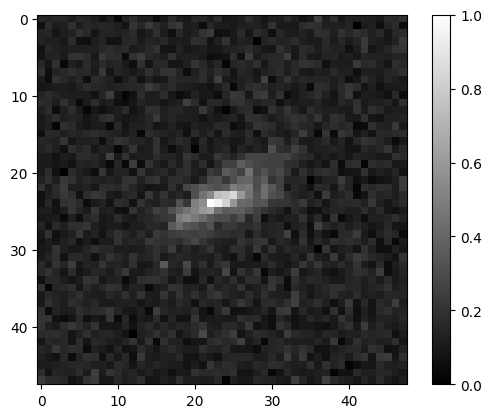

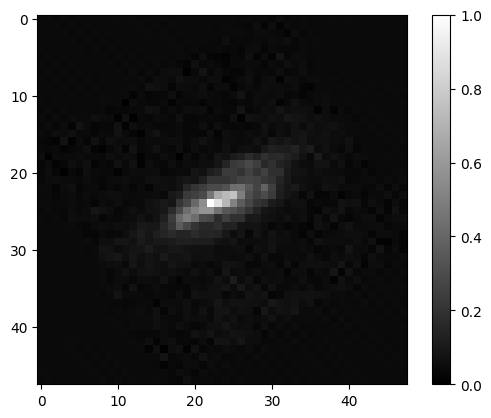

In [16]:
#img_data = np.random.permutation(img_data)
img_data = normalize_list(img_data)
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_split = 0.7
train_idx = int(num_total * train_split)

img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
img_shape = img_data[0].shape

# Spliting training and testing
train = img_data[0:train_idx]

train_x = img_data[[i for i in range(0, len(train), 2)]]
train_y = img_data[[i for i in range(1, len(train), 2)]]

test = img_data[train_idx:num_total]
test_x = img_data[[i for i in range(0, len(test), 2)]]
test_y = img_data[[i for i in range(1, len(test), 2)]]

idx = 0
show_image(test_x[idx])
show_image(test_y[idx])

In [17]:
model = resUnet(input_shape=img_shape, num_filters=64, num_resnetblocks=4, kernel_size=3)
model.summary()
model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=[Accuracy()])

# Train the model
# batch_size = 32
# epochs = 10

# model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=batch_size, epochs=epochs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 48, 48, 64)           0         ['batch_normalization[0][0